## 2023-05-15 확인: initialize_v2 / momentum_strategy_v2 에 잘 작동합니다

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm

from tools_ryu import mytool
from multi_run.initialize_v2 import data_pp, make_market_index
from multi_run.momentum_strategy_v3 import *

2023-05-15 22:59:20,275	INFO worker.py:1625 -- Started a local Ray instance.
2023-05-15 22:59:24,882	INFO worker.py:1454 -- Calling ray.init() again after it has already been called.


In [2]:
# Binance Data는 코드 수정해야함
cmktcap = pd.read_pickle("Data/cmktcap_data_final.pickle")
#cmktcap_reduced = pd.read_pickle("Data/cmktcap_data_reduced.pickle")
#binance = pd.read_pickle("Data/binance_data_pp.pickle")

In [3]:
#값들 설정          mktcap, volume
group_value = {"M0":[1_000_000, None],
               "M1":[1_000_000,1_000_000],
               "M2":[1_000_000,5_000_000]}

In [4]:
# Initialize the Data
cmkt_data = data_pp(cmktcap, vender="coinmarketcap")
#cmktre_data = data_pp(cmktcap_reduced, vender="coinmarketcap")
#binance_data = data_pp(binance, vender="binance")

In [5]:
# Ray Data 생성
ray_price = ray.put(cmkt_data["price"])
ray_mktcap = ray.put(cmkt_data["mktcap"])
ray_vol = ray.put(cmkt_data["vol"])

# Binance Data 생성
#ray_price_b = ray.put(binance_data["price"])
#ray_mktcap_b = ray.put(binance_data["mktcap"])
#ray_vol_b = ray.put(binance_data["vol"])

In [6]:
# Terra Luna 제거

#price_pp = cmkt_data["price"].drop("4172", axis=1)
#mktcap_pp = cmkt_data["mktcap"].drop("4172", axis=1)
#vol_pp = cmkt_data["vol"].drop("4172", axis=1)

In [7]:
# Ray Data 생성
#ray_price = ray.put(price_pp)
#ray_mktcap = ray.put(mktcap_pp)
#ray_vol = ray.put(vol_pp)

# 1. Market Index 생성

In [ ]:
# 코인 마켓 인덱스 생성  리턴값 -> mkt_index, time_series_coin_num
market_index_cmkt = {}

mkt_future = [make_market_index.remote(price_df=ray_price,
                                       mktcap_df=ray_mktcap,
                                       vol_df=ray_vol,
                                       mktcap_thresh=value_lst[0],
                                       vol_thresh=value_lst[1]) 
              for key, value_lst in group_value.items()]

mkt_result = ray.get(mkt_future)

In [ ]:
mkt_result_dict = {"M0":mkt_result[0],
                   "M1":mkt_result[1],
                   "M2":mkt_result[2],}
                   #"M4":mkt_result[3]}

In [ ]:
mytool.draw_return_result(mkt_result_dict, 
                          title="",
                          log=False)

In [ ]:
mkt_result_dict["M2"]

In [ ]:
mytool.print_statistics(mkt_result_dict)

# 2. 모멘텀 전략 (Value Weighted)

In [ ]:
days_lst = ["MON","TUE","WED","THU","FRI","SAT","SUN"]

In [8]:
momentum_cmkt = {}

momentum_future = [weekly_momentum_value_weighted.remote(price_df=ray_price,
                                                         mktcap_df=ray_mktcap,
                                                         vol_df=ray_vol,
                                                         n_group=5,
                                                         day_of_week="SUN",
                                                         number_of_coin_group=20,
                                                         mktcap_thresh=value_lst[0],
                                                         vol_thresh=value_lst[1],
                                                         fee_rate=0.0015,
                                                         freq="Weekly") 
                   
              for key, value_lst in group_value.items()]

momentum_result = ray.get(momentum_future)

(pid=21340) 2023-05-15 22:59:40,432	INFO worker.py:1454 -- Calling ray.init() again after it has already been called.


In [9]:
momentum_result_dict = {"M0":momentum_result[0],
                        "M1":momentum_result[1],
                        "M2":momentum_result[2]}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

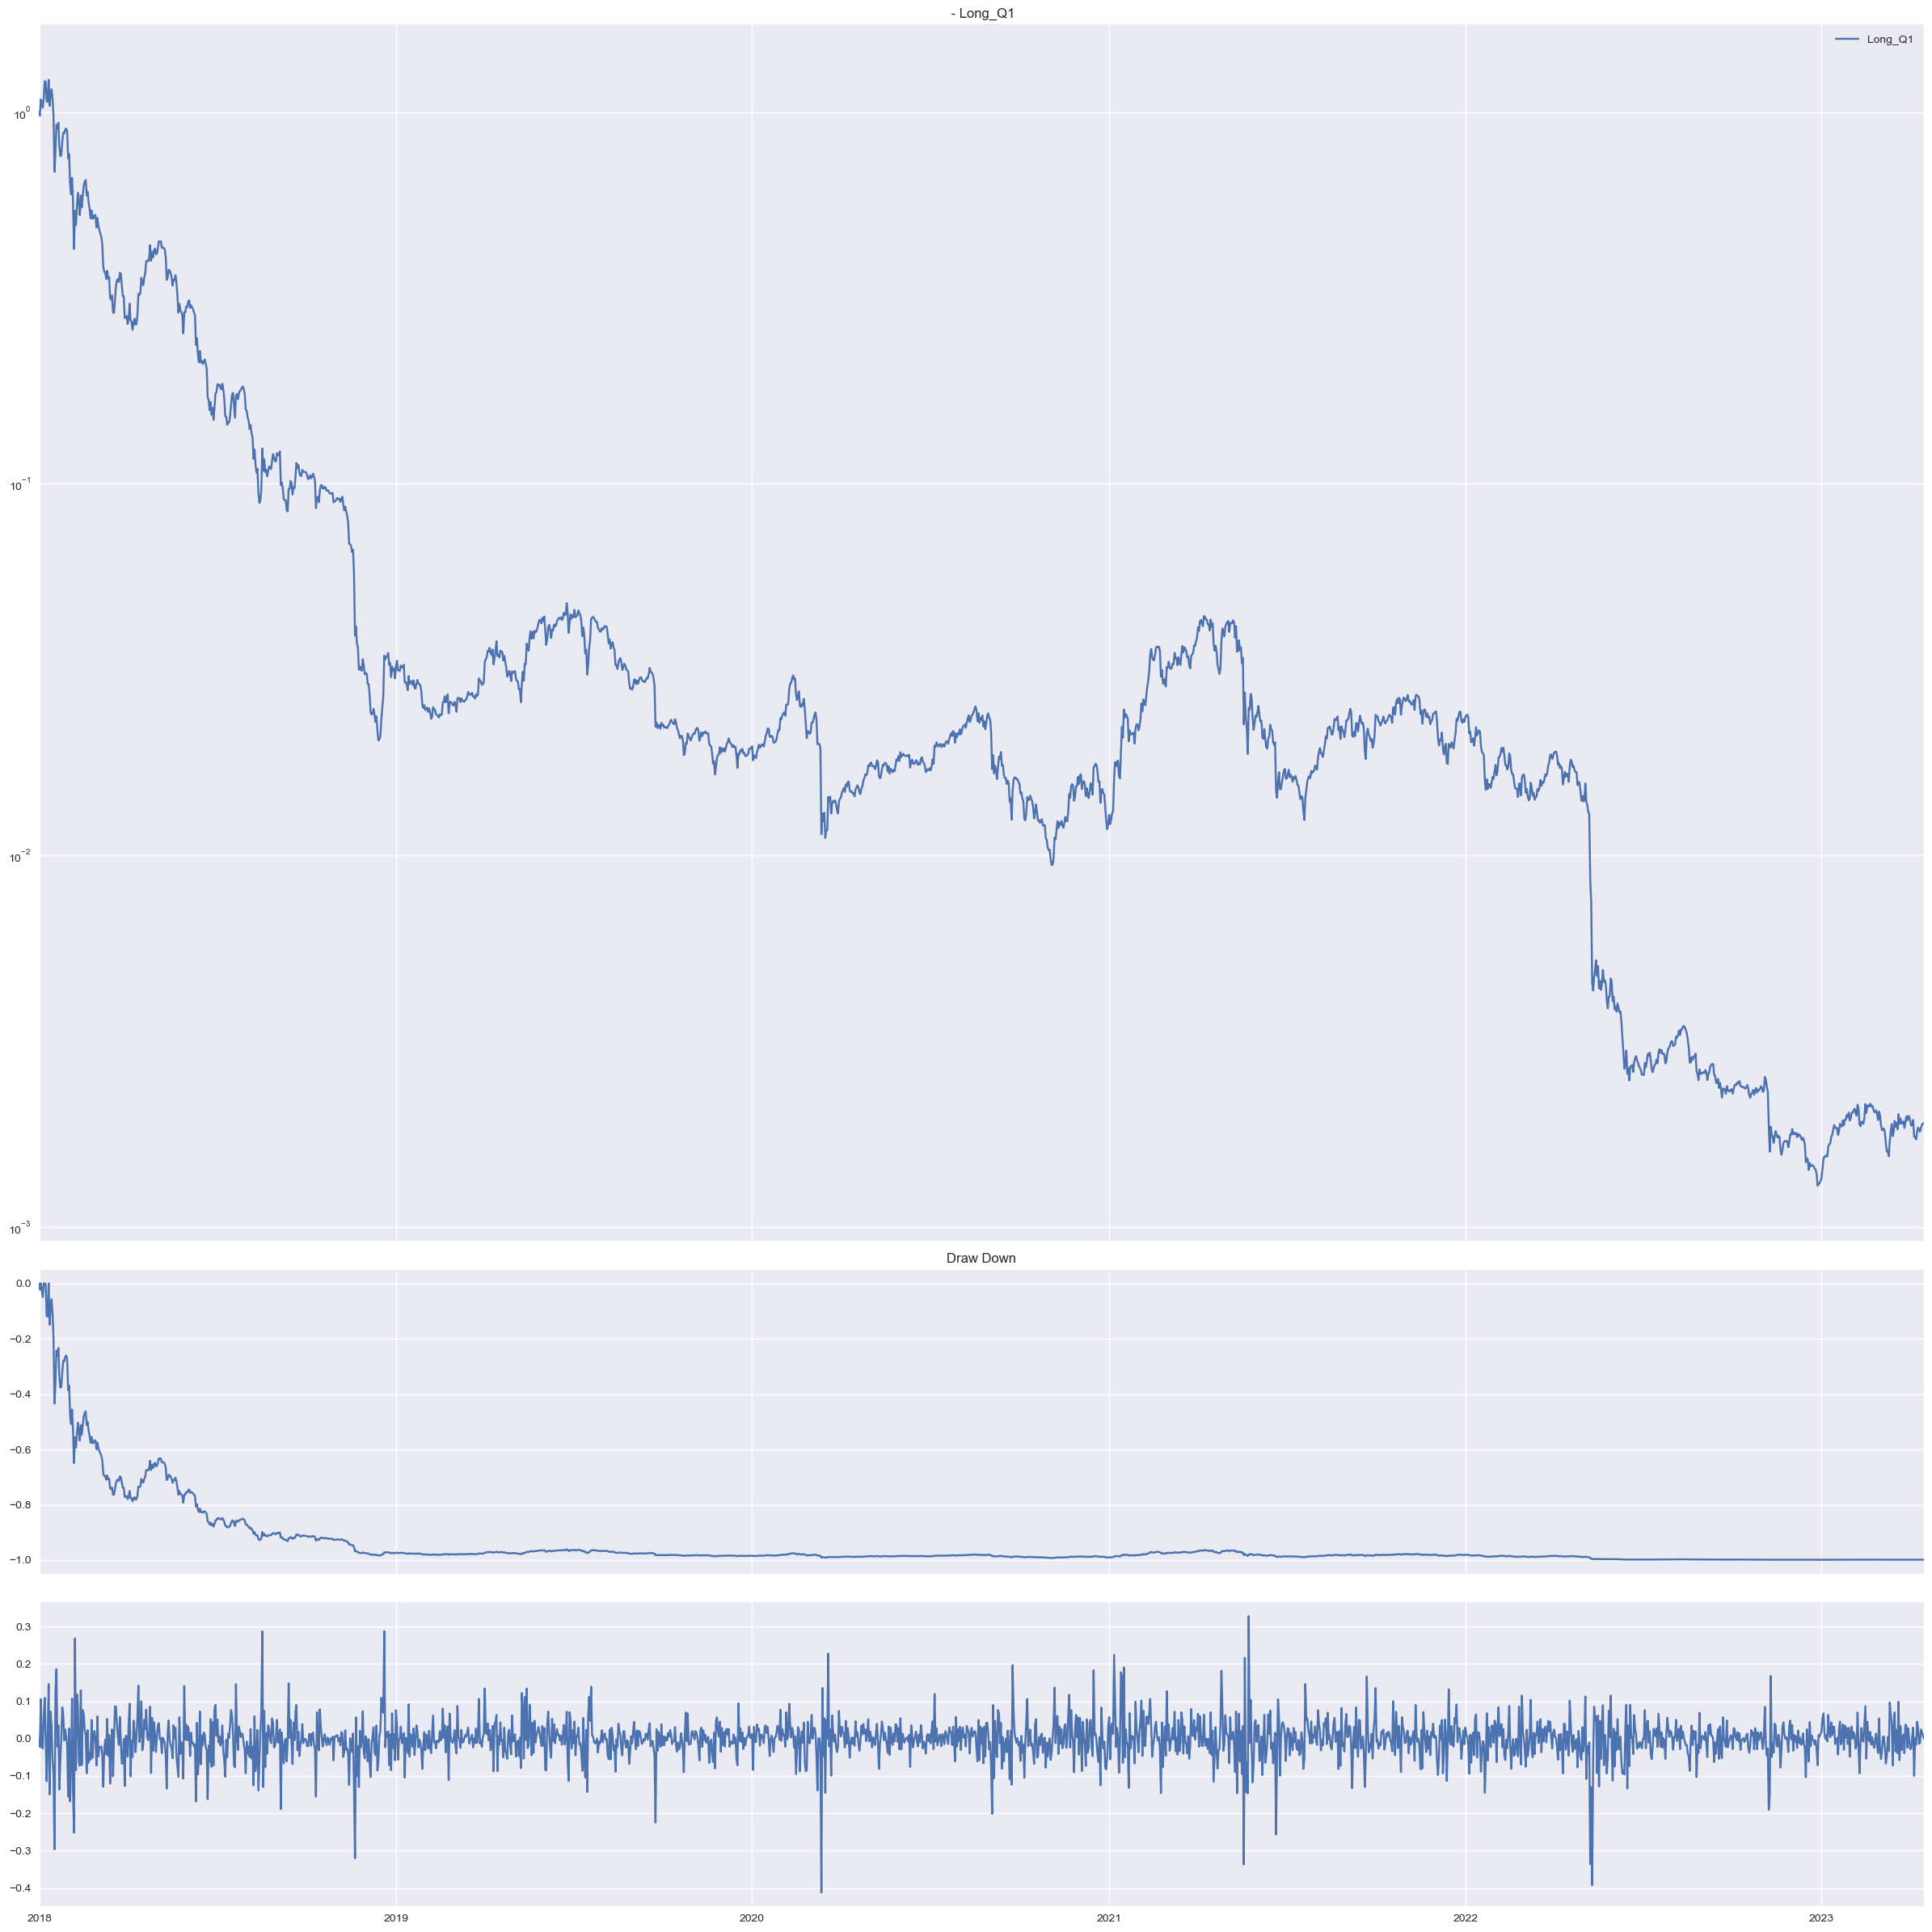

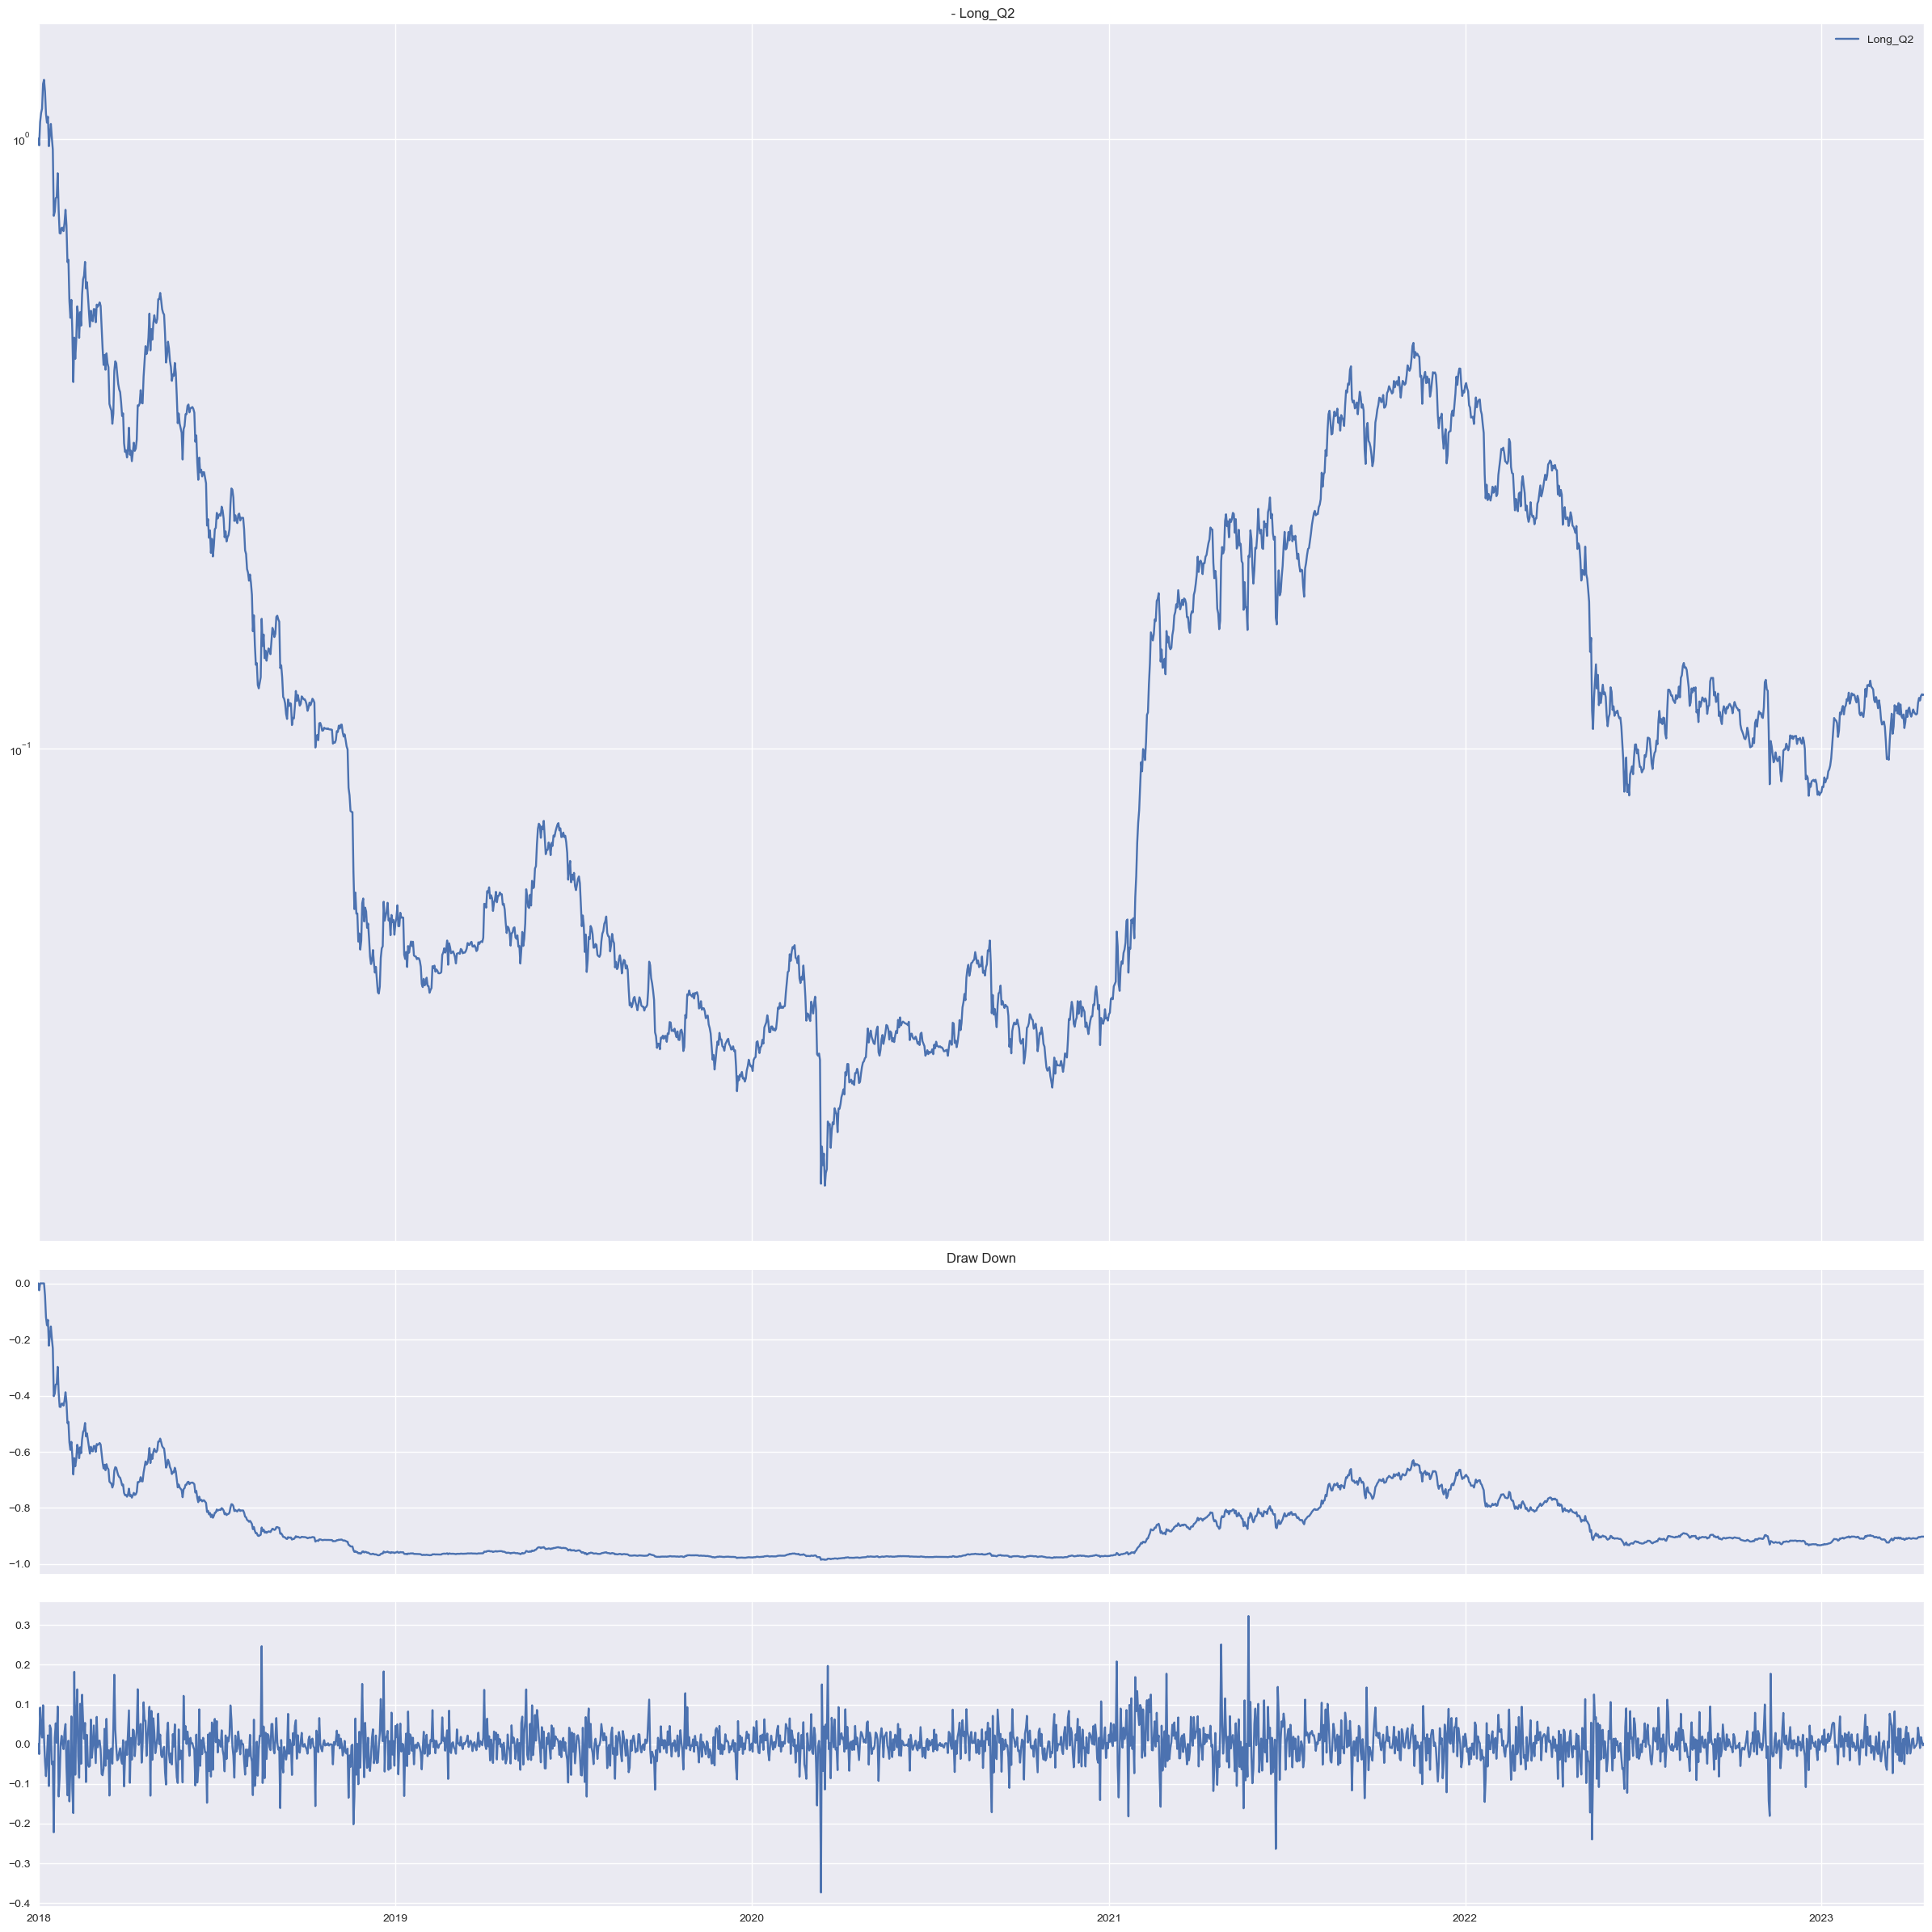

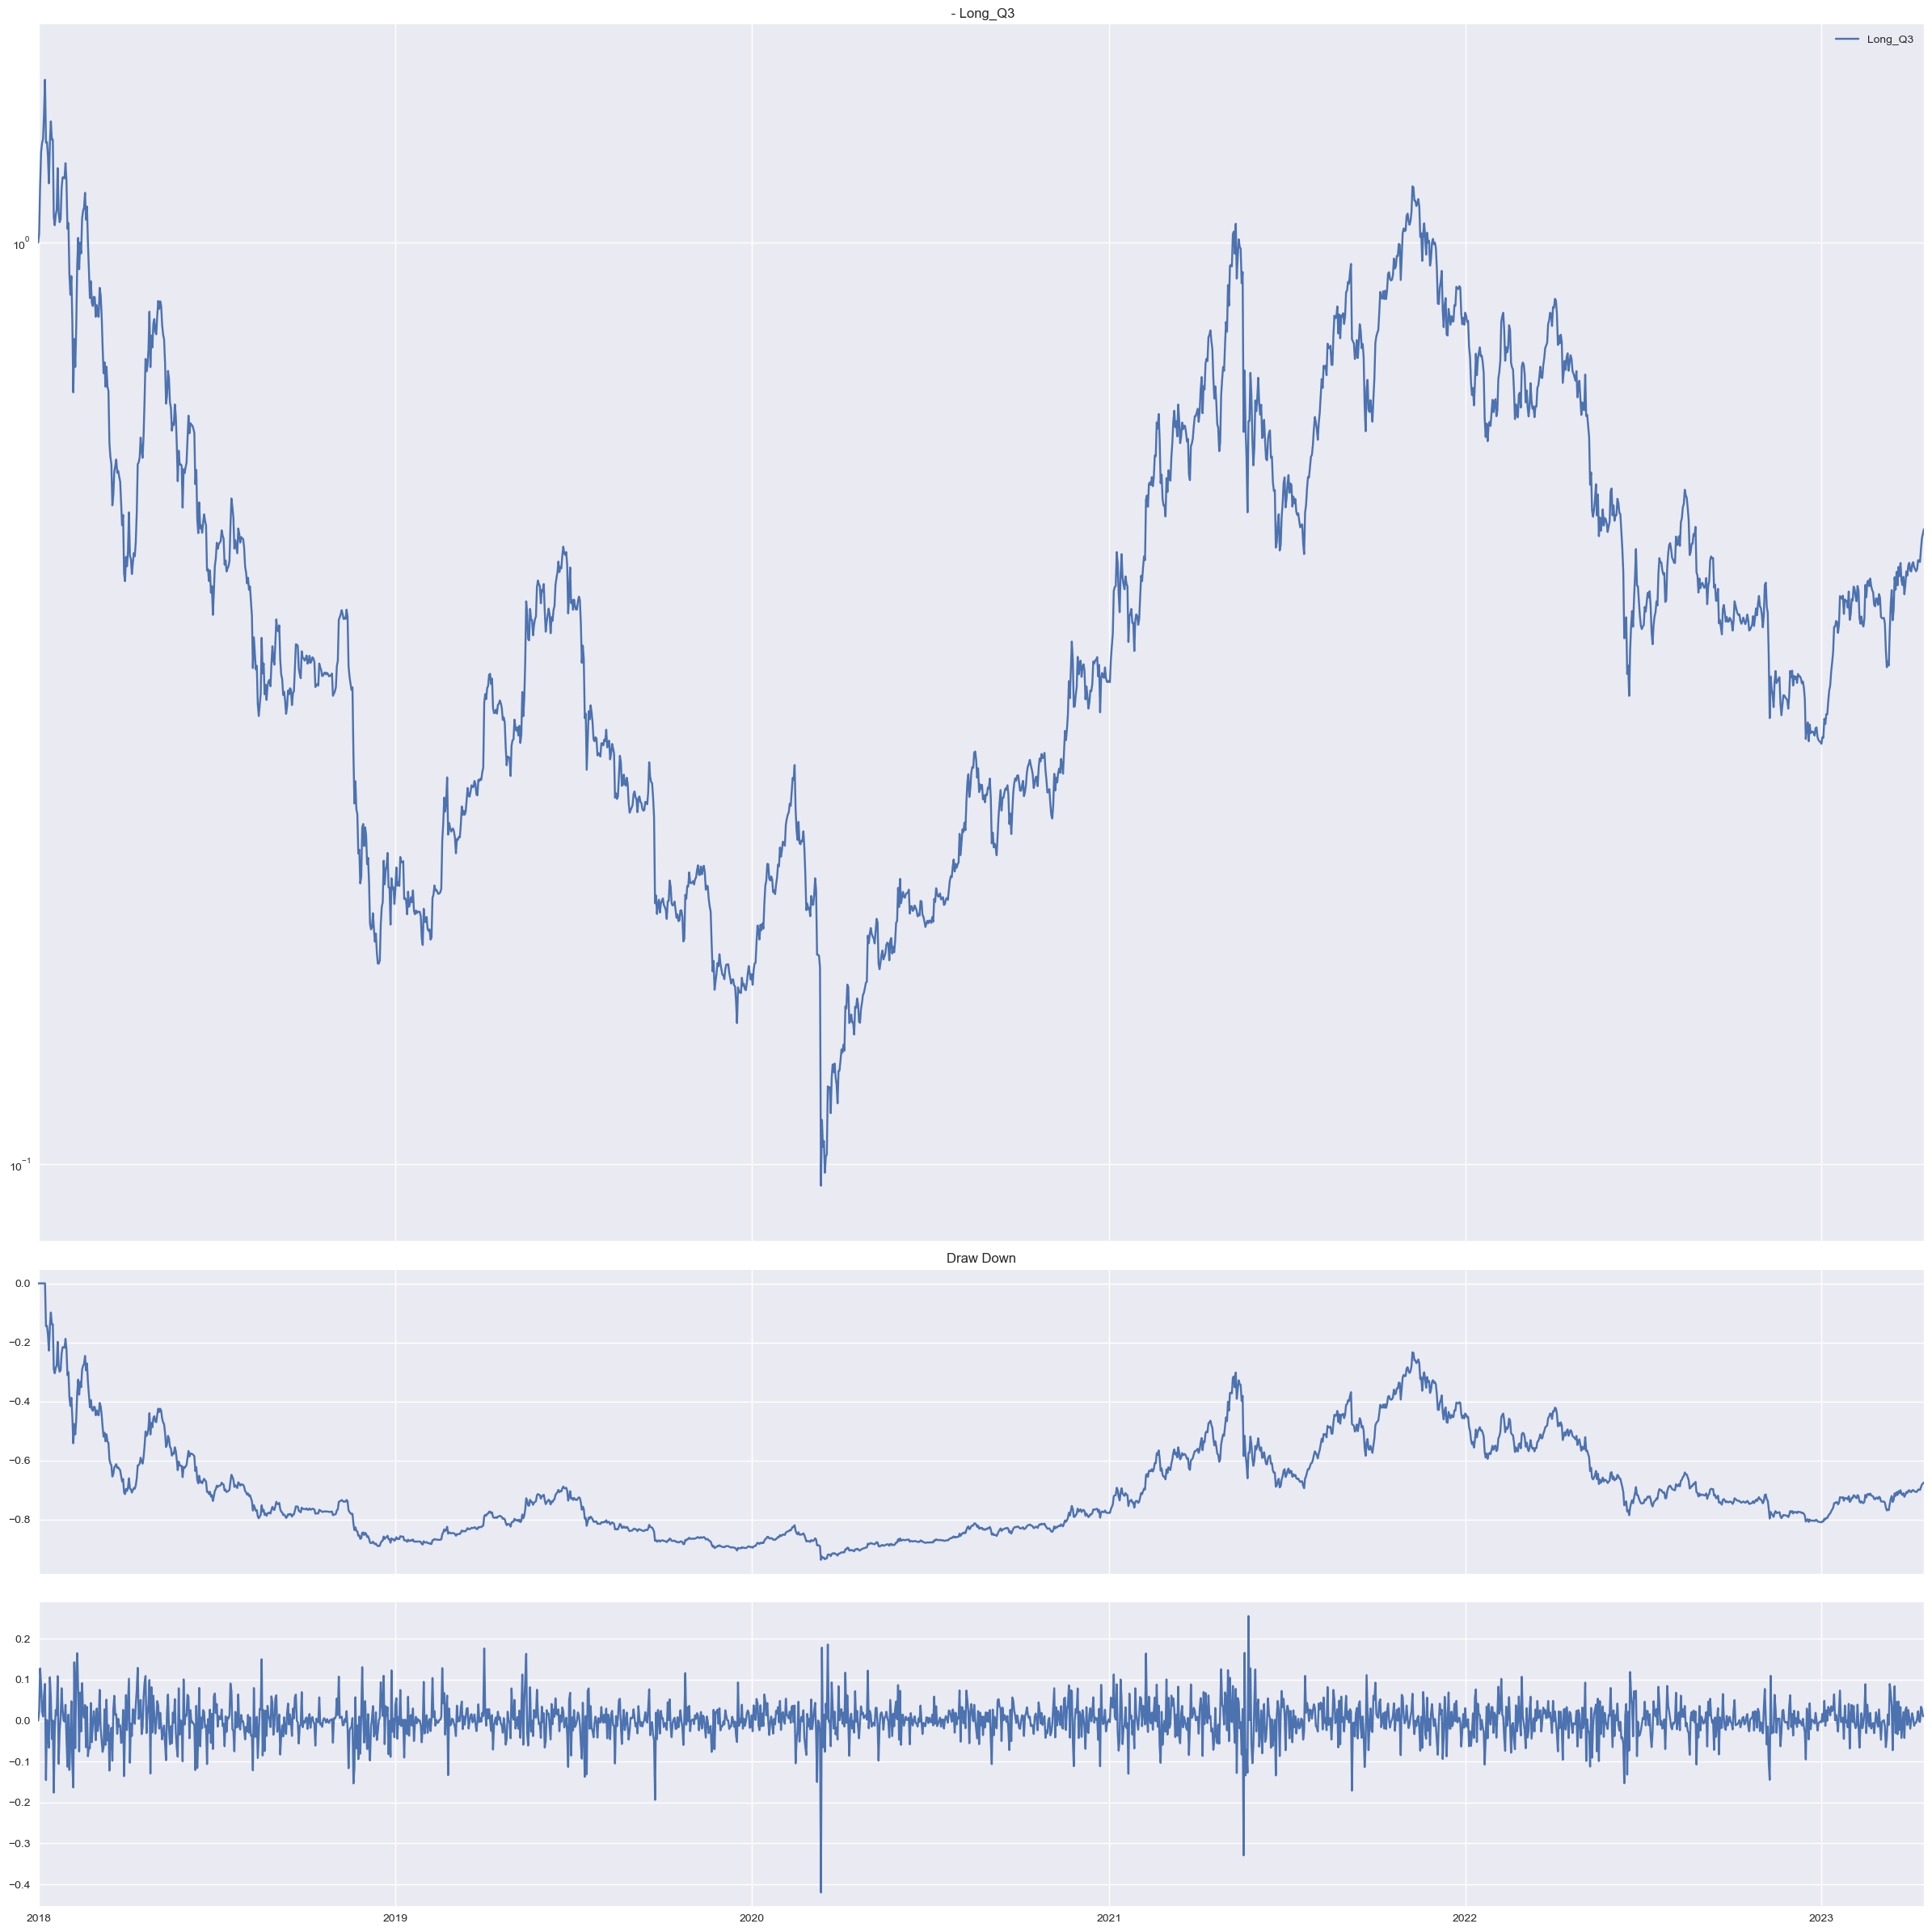

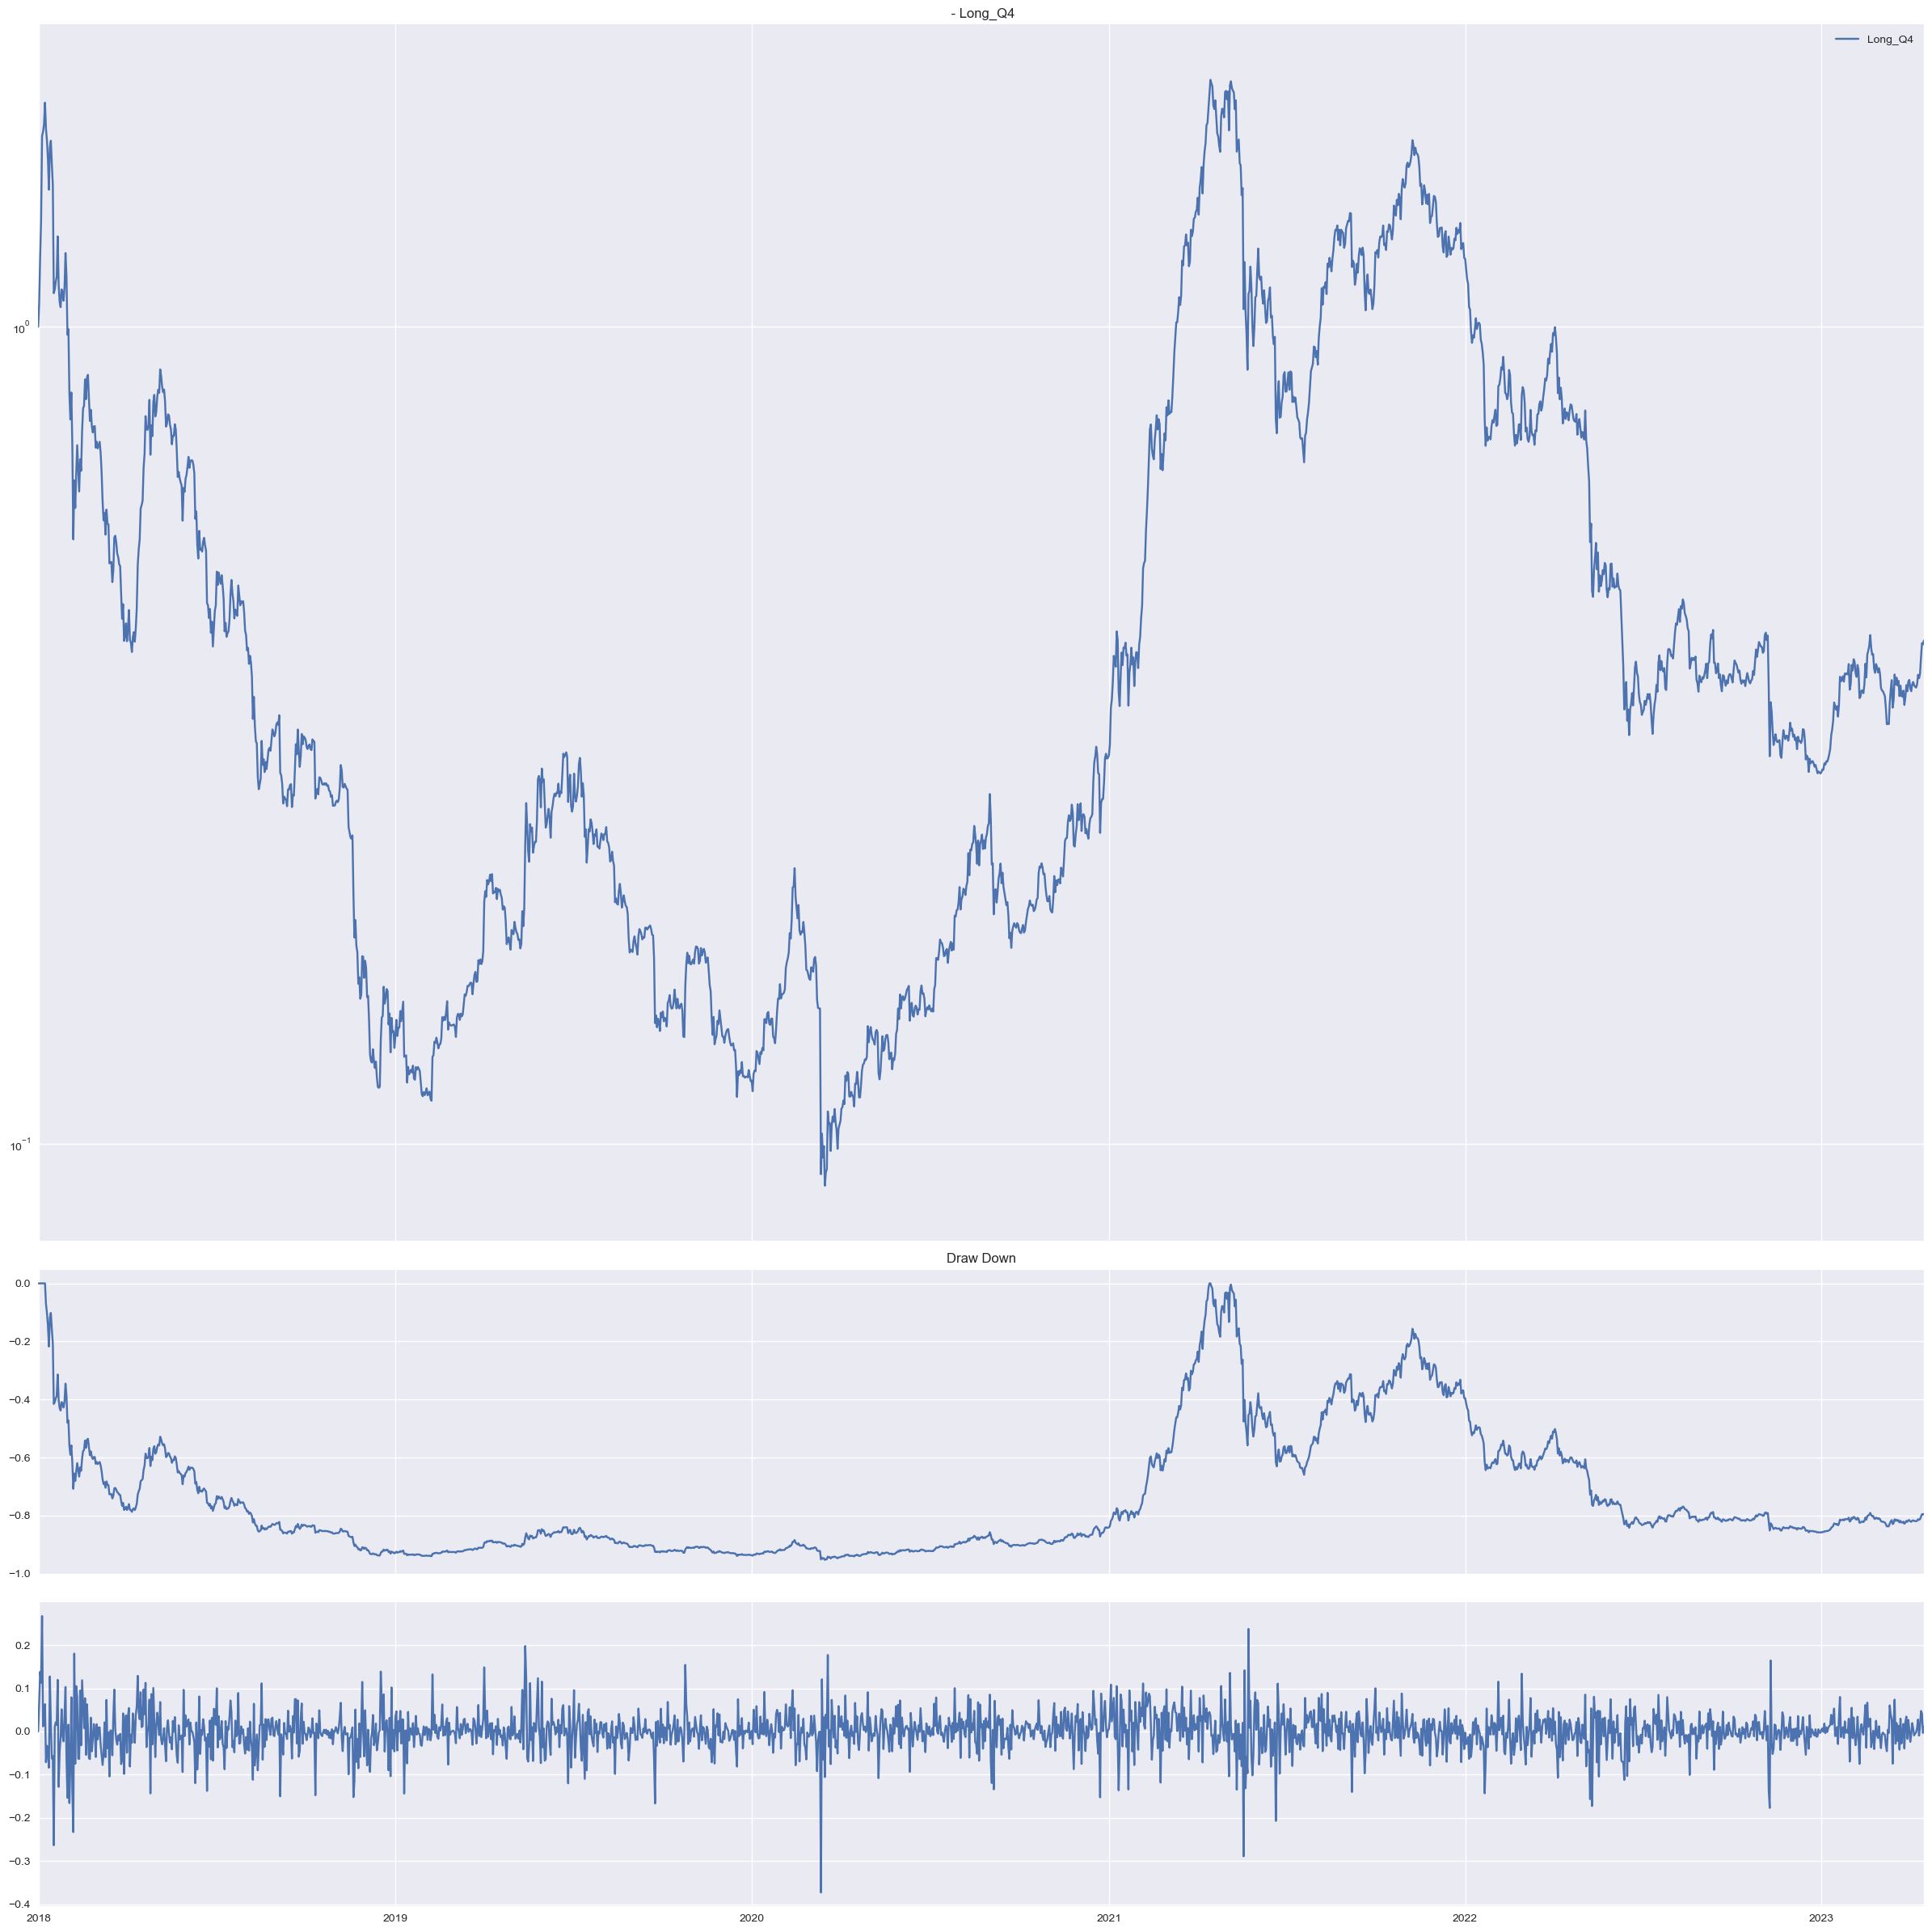

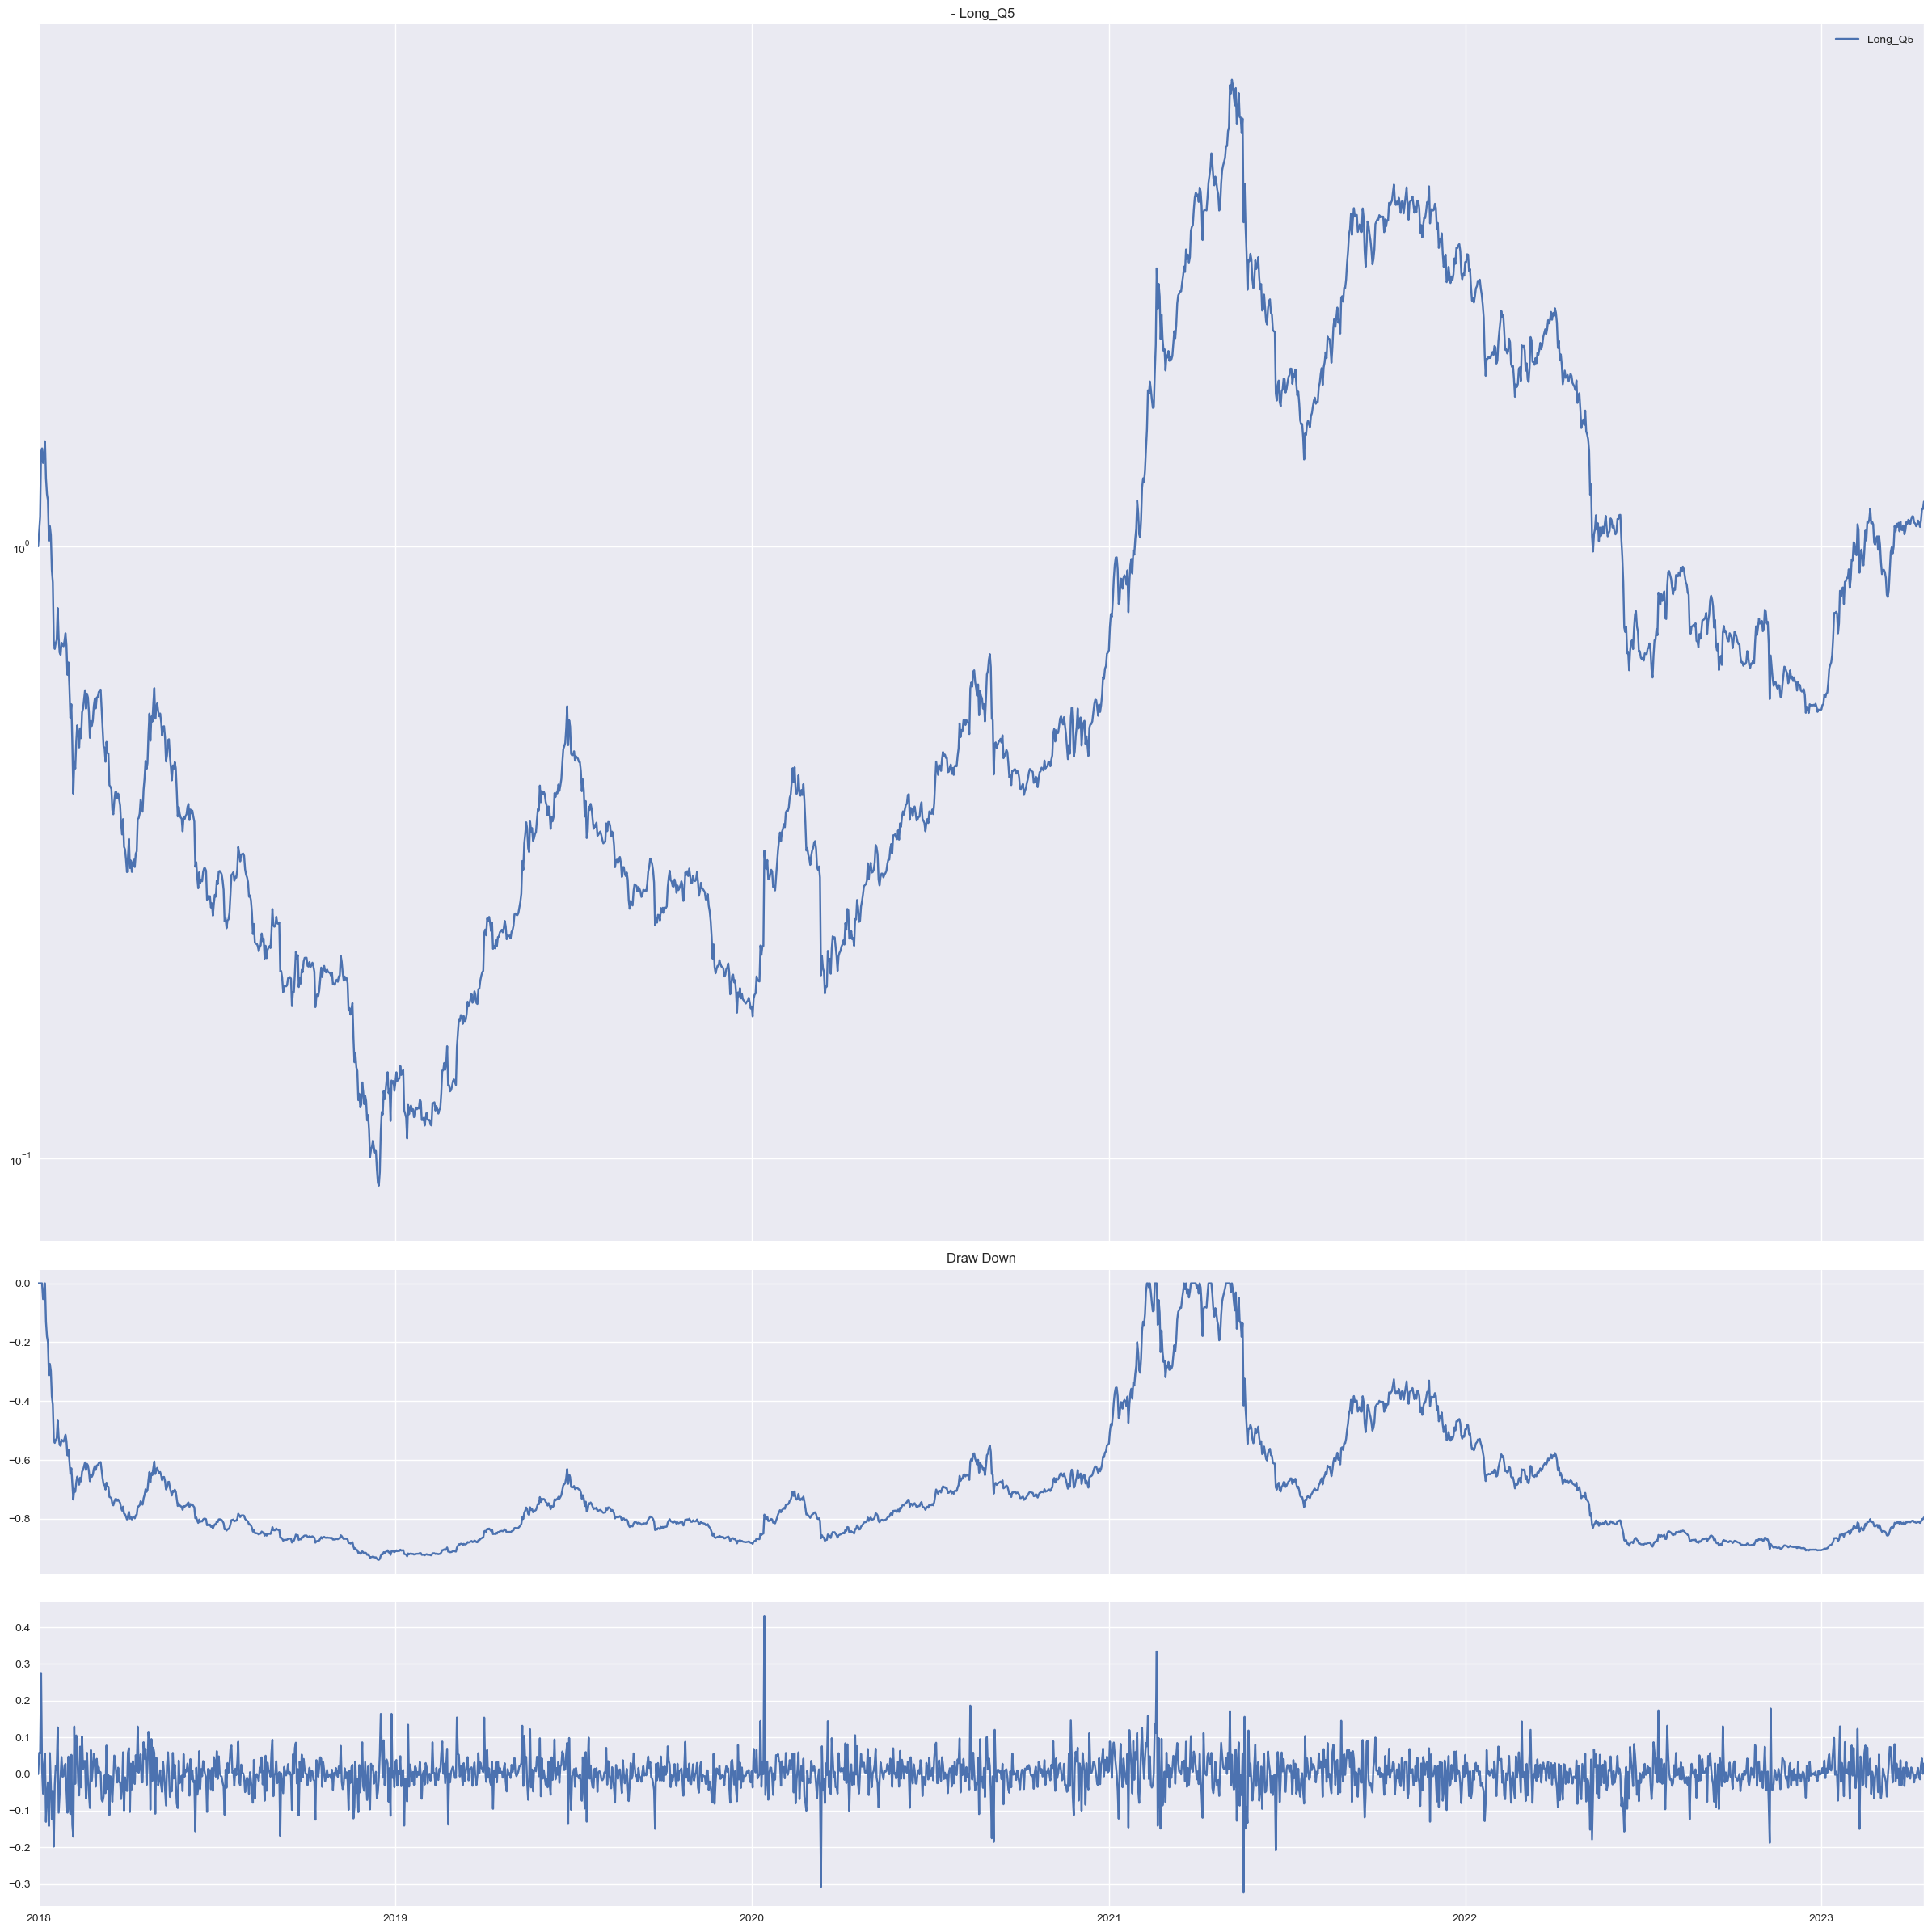

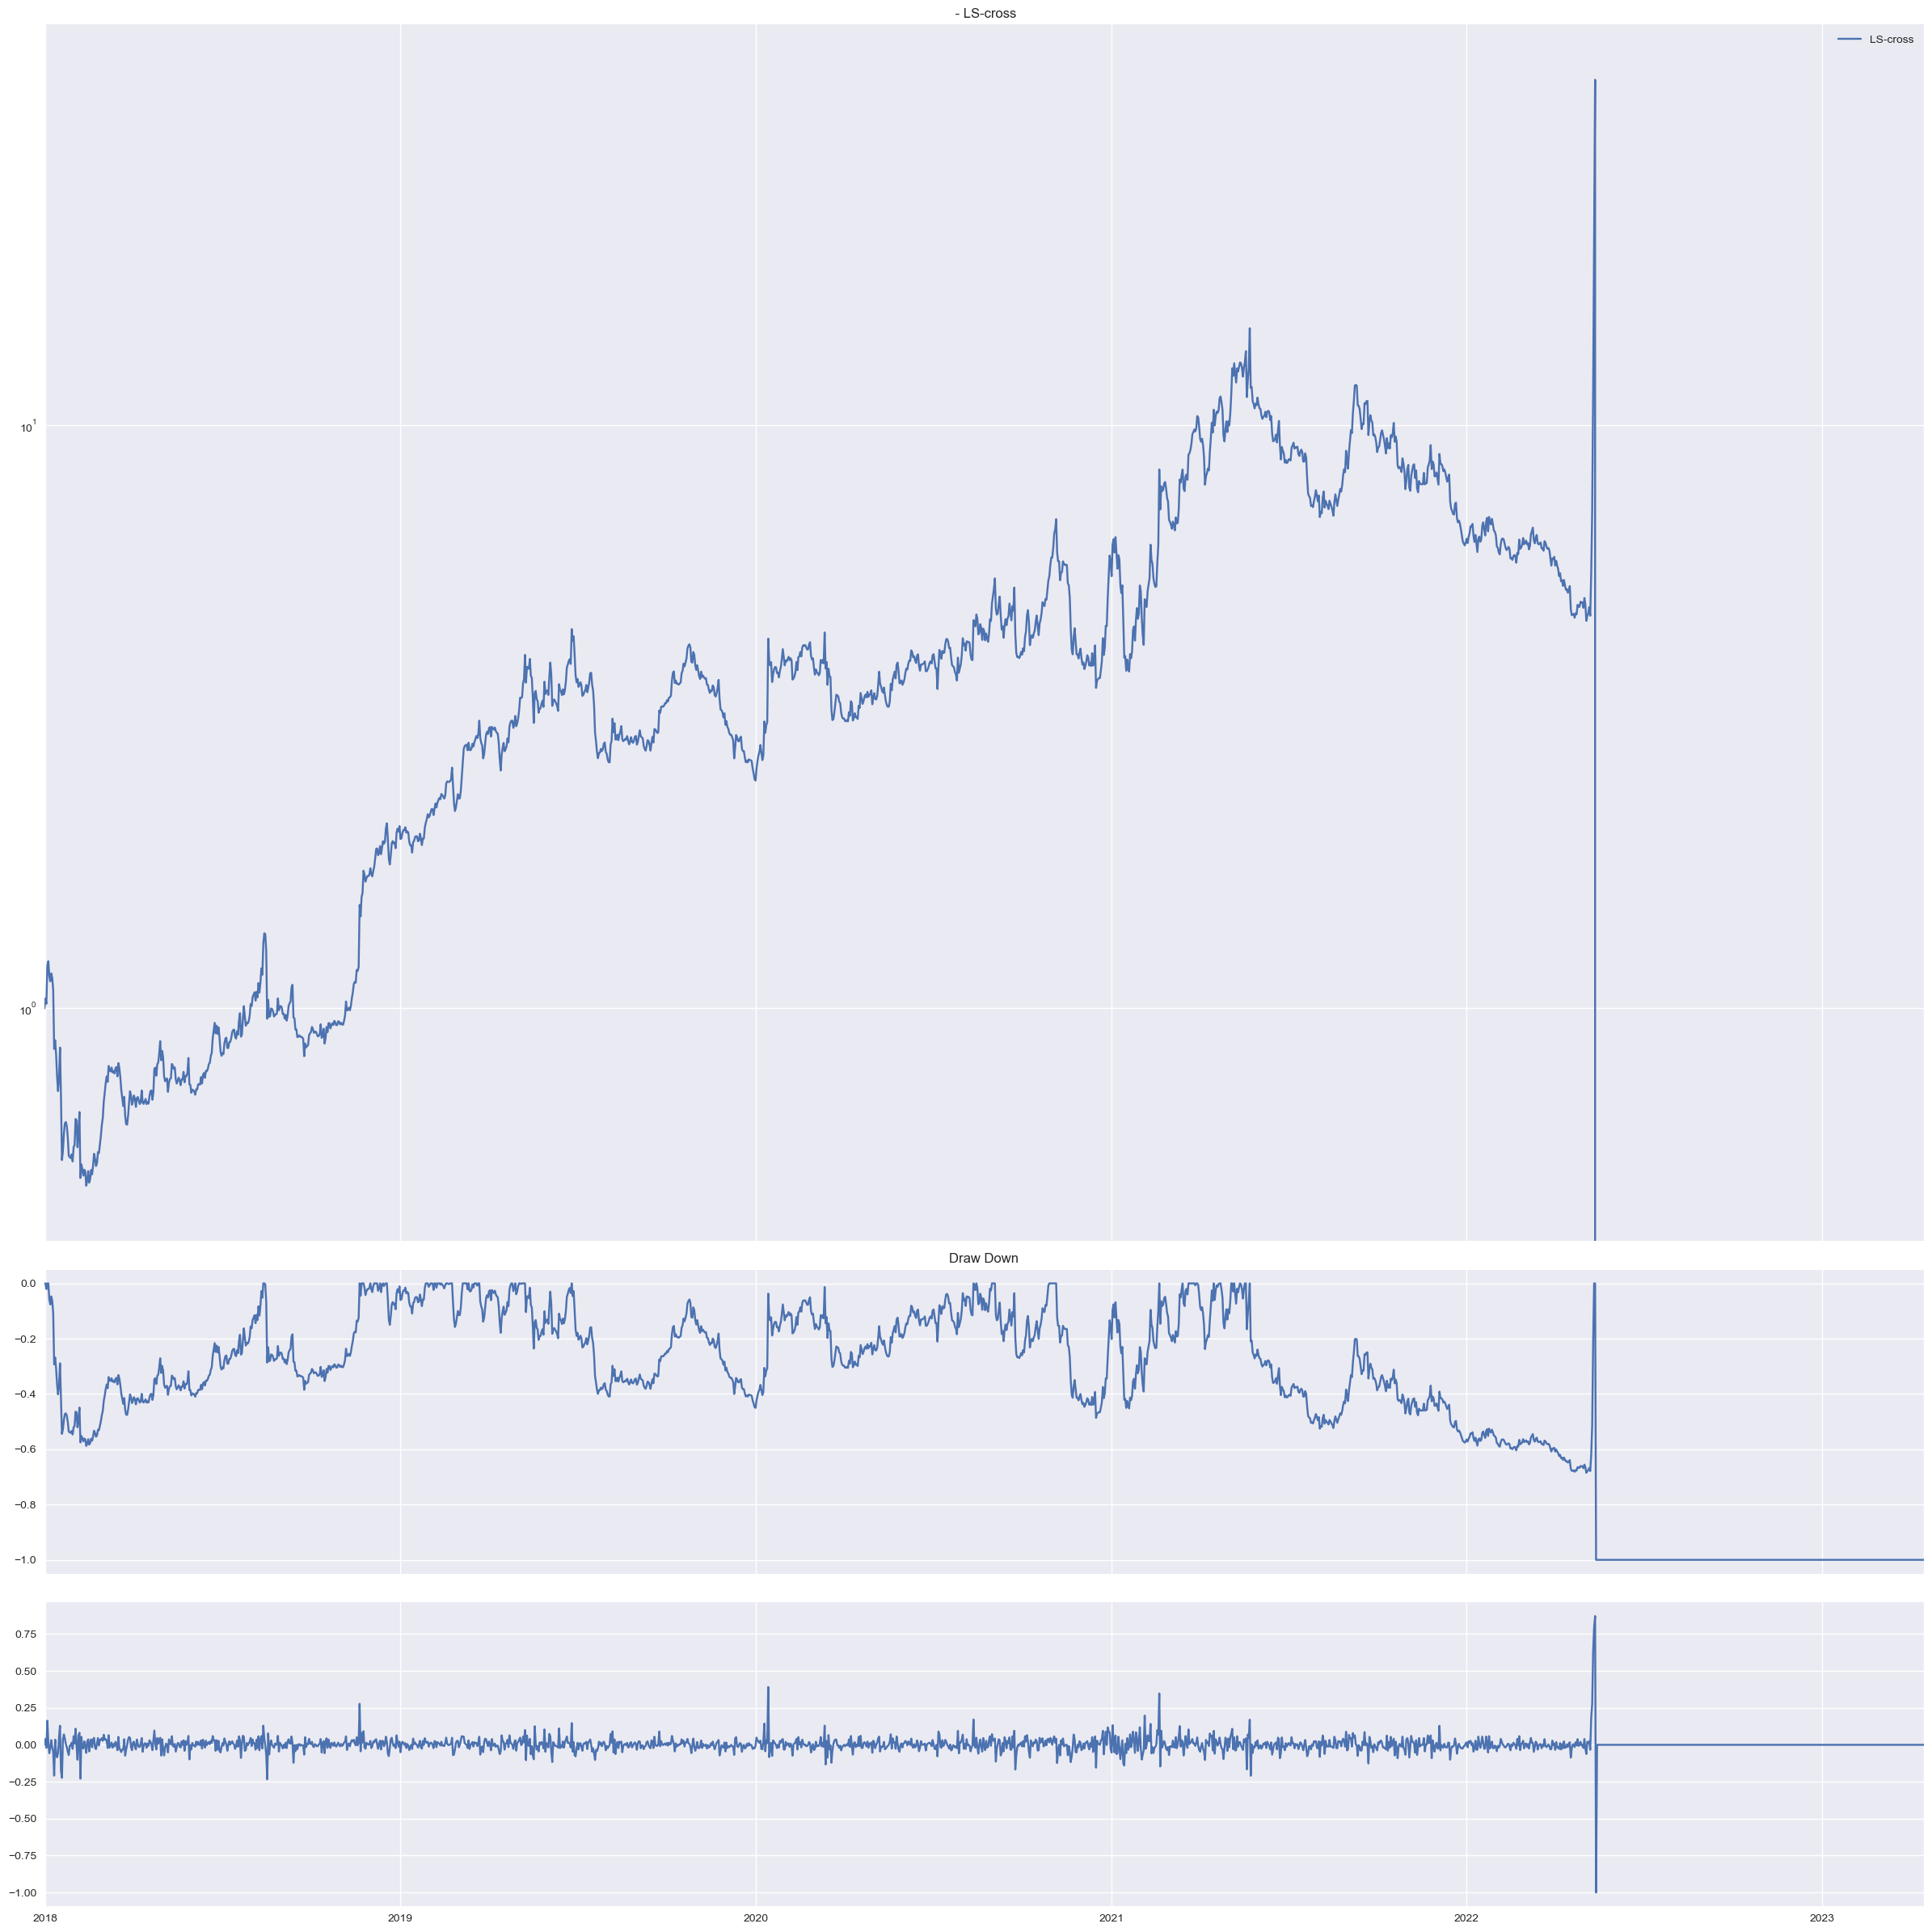

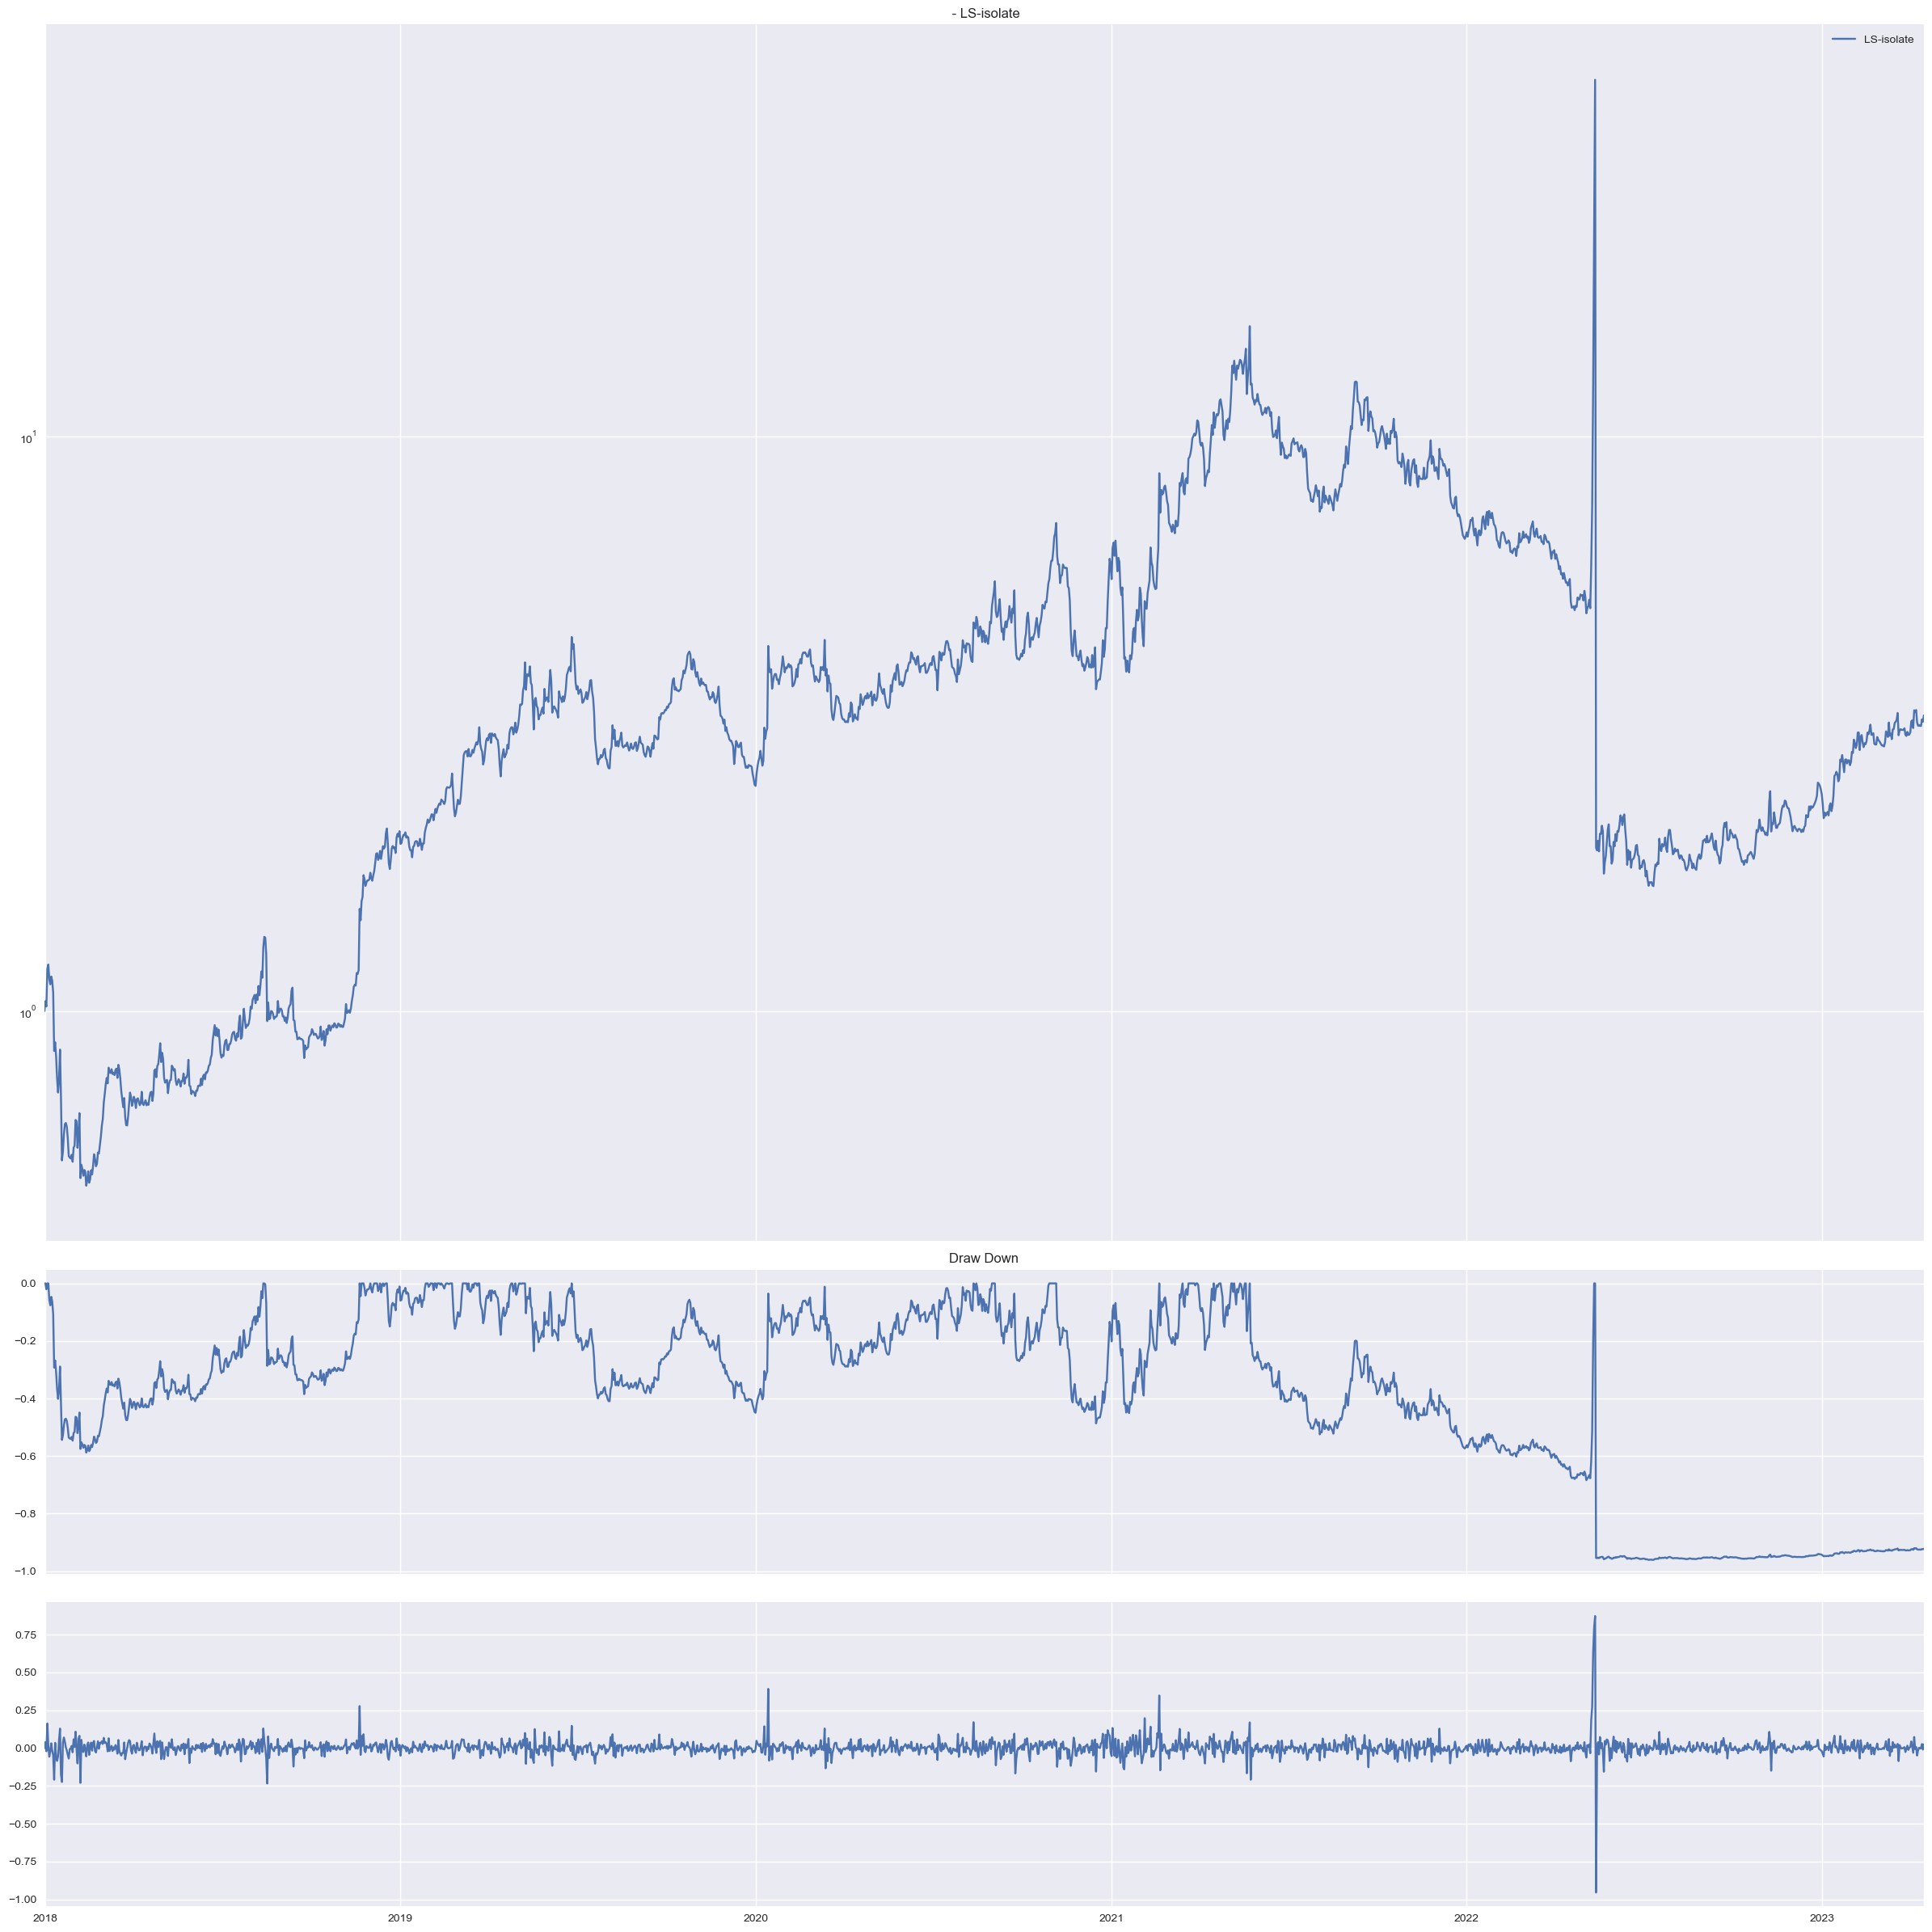

In [12]:
mytool.draw_return_result(momentum_result_dict["M2"], 
                         title="",
                        log=True)

In [11]:
mytool.print_statistics(momentum_result_dict["M2"])

,Long_Q1,Long_Q2,Long_Q3,Long_Q4,Long_Q5,LS-cross,LS-isolate
CAGR,-0.692700,-0.324200,-0.130200,-0.164100,0.021400,-1.000000,0.241700
Mean,-0.605290,0.046130,0.255340,0.233390,0.495250,0.903020,1.054340
STD,1.053275,0.933380,0.871330,0.883951,0.960495,1.051565,1.071682
MDD,0.999000,0.985000,0.937000,0.953000,0.939000,1.000000,0.960000
Sharpe,-0.574674,0.049423,0.293046,0.264030,0.515620,0.858739,0.983818


In [ ]:
what = "Long_Q5"

a = {"M0":momentum_result_dict["M0"][what].loc["2017-12-31":],
"M1":momentum_result_dict["M1"][what].loc["2017-12-31":],
"M2":momentum_result_dict["M2"][what].loc["2017-12-31":]}

In [ ]:
mytool.print_statistics(a)

In [ ]:
mytool.draw_return_result(a, title=f"{what} Result 2018~", log=True,
                          one_plot=True)

Binance

In [ ]:
# Binance Data
momentum_binance = {}
momentum_future_binance = [weekly_momentum_value_weighted.remote(price_df=ray_price_b,
                                                                 mktcap_df=ray_mktcap_b,
                                                                 vol_df=ray_vol_b,
                                                                 n_group=4,
                                                                 day_of_week="SUN",
                                                                 number_of_coin_group=10,
                                                                 mktcap_thresh=value_lst[0],
                                                                 vol_thresh=value_lst[1],
                                                                 fee_rate=0.0015) 
                          for key, value_lst in group_value.items()]

momentum_result_b = ray.get(momentum_future_binance)

In [ ]:
momentum_result_dict_b = {"M0":momentum_result_b[0],
                        "M1":momentum_result_b[1],
                        "M2":momentum_result_b[2]}

In [ ]:
mytool.draw_return_result(momentum_result_dict_b["M1"], 
                          title="",
                          log=False)

# 3. Value Weighted, Marketcap Capped 

In [ ]:
momentum_capped_cmkt = {}

momentum_capped_future = [weekly_momentum_value_weighted_capped.remote(price_df=ray_price,
                                                                       mktcap_df=ray_mktcap,
                                                                       vol_df=ray_vol,
                                                                       n_group=5,
                                                                       day_of_week="SUN",
                                                                       number_of_coin_group=20,
                                                                       mktcap_thresh=value_lst[0],
                                                                       vol_thresh=value_lst[1],
                                                                       fee_rate=0.0015,
                                                                       num_cap=5) 
              for key, value_lst in group_value.items()]

momentum_capped_result = ray.get(momentum_capped_future)

In [ ]:
momentum_capped_result_dict = {"M0":momentum_capped_result[0],
                               "M1":momentum_capped_result[1],
                               "M2":momentum_capped_result[2],}
                               #"M4":momentum_capped_result[3]}

In [ ]:
mytool.draw_return_result(momentum_capped_result_dict["M2"], 
                          title="",
                          log=True)

In [ ]:
mytool.print_statistics(momentum_capped_result_dict["M2"])

In [ ]:
b = {"M0":momentum_capped_result_dict["M0"]["Long-Short"].loc["2018":],
"M1":momentum_capped_result_dict["M1"]["Long-Short"].loc["2018":],
"M2":momentum_capped_result_dict["M2"]["Long-Short"].loc["2018":]}

In [ ]:
mytool.draw_return_result(b,
                          title="Long-Short After 2018~",
                          log=False,
                          one_plot=True)

In [ ]:
mytool.print_statistics(b)

# 4. 모멘텀 전략 (Momentum Weighted) 

In [ ]:
momentum_weighted_cmkt = {}

momentum_weighted_future = [weekly_momentum_momentum_weighted.remote(price_df=ray_price,
                                                                   mktcap_df=ray_mktcap,
                                                                   vol_df=ray_vol,
                                                                   n_group=5,
                                                                   day_of_week="SUN",
                                                                   number_of_coin_group=20,
                                                                   mktcap_thresh=value_lst[0],
                                                                   vol_thresh=value_lst[1],
                                                                   fee_rate=0.0015) 
              for key, value_lst in group_value.items()]

momentum_weighted_result = ray.get(momentum_weighted_future)

In [ ]:
momentum_weighted_result_dict = {"M1":momentum_weighted_result[0],
                                 "M2":momentum_weighted_result[1],
                                 "M3":momentum_weighted_result[2],
                                 "M4":momentum_weighted_result[3]}

In [ ]:
mytool.draw_return_result(momentum_weighted_result_dict["M4"], 
                          title="",
                          log=False);

In [ ]:
mytool.print_statistics(momentum_weighted_result_dict["M3"])

# 5. 모멘텀 전략 Weight Capped (Momentum Weighted) 

In [ ]:
momentum_weighted_capped_cmkt = {}

momentum_weighted_capped_future = [weekly_momentum_momentum_weighted_capped.remote(price_df=ray_price,
                                                                                   mktcap_df=ray_mktcap,
                                                                                   vol_df=ray_vol,
                                                                                   n_group=5,
                                                                                   day_of_week="SUN",
                                                                                   number_of_coin_group=20,
                                                                                   mktcap_thresh=value_lst[0],
                                                                                   vol_thresh=value_lst[1],
                                                                                   fee_rate=0.0015,
                                                                                   num_cap=5) 
              for key, value_lst in group_value.items()]

momentum_weighted_capped_result = ray.get(momentum_weighted_capped_future)

In [ ]:
momentum_weighted_capped_result_dict = {"M1":momentum_weighted_capped_result[0],
                                        "M2":momentum_weighted_capped_result[1],
                                        "M3":momentum_weighted_capped_result[2],
                                        "M4":momentum_weighted_capped_result[3]}

In [ ]:
mytool.draw_return_result(momentum_weighted_capped_result_dict["M4"], 
                          title="",
                          log=False);

In [ ]:
mytool.print_statistics(momentum_weighted_capped_result_dict["M4"])